# Example Notebook for a classifier

## 0. set log-level of sam_ml library [can be ignored]

(e.g. debugging)

NOTE: has to happen before importing the sam_ml library

In [1]:
import os
os.environ["SAM_ML_LOG_LEVEL"] = "info"

## 1. libraries

In [2]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from sam_ml.models import LR, __all__
from sam_ml.data.preprocessing import Embeddings_builder, Sampler, Scaler, Selector

## 2. data

**Note:** All data classes (*Embeddings_builder*, *Sampler*, *Scaler*, *Selector*) have a static function .params() which returns the possible parameter values for the class

In [3]:
print(Embeddings_builder.params())
print(Scaler.params())
print(Selector.params())
print(Sampler.params())

{'vec': ['bert', 'count', 'tfidf']}
{'scaler': ['standard', 'minmax', 'maxabs', 'robust', 'normalizer', 'power', 'quantile', 'quantile_normal']}
{'algorithm': ['kbest', 'kbest_chi2', 'pca', 'wrapper', 'sequential', 'select_model', 'rfe', 'rfecv'], 'estimator': [LinearSVC(dual=False, penalty='l1'), LogisticRegression(), ExtraTreesClassifier(n_estimators=50)]}
{'algorithm': ['SMOTE', 'rus', 'ros', 'tl', 'nm']}


**Note:** do not forget to change the *train_on* parameter of the data class methods depending if the data is train or test data

### 2.1. load dataset

In [4]:
df = load_iris()
y = pd.Series(df.target)
X = pd.DataFrame(df.data, columns=df.feature_names)
x_train, x_test, y_train, y_test = train_test_split(X,y, train_size=0.80, random_state=42)

### 2.2. build embeddings [not needed for iris dataset]

Vectorizers convert text into vectors which is needed for string columns because ml models often can just deal with numeric or boolean features

In [ ]:
'''
eb = Embeddings_builder(vec="tfidf")
x_train_pre = eb.vectorize(x_train["string_columns"], train_on=True)
x_test_pre = eb.vectorize(x_test["string_columns"], train_on=False)
'''

### 2.3. scaling

Scaling algorithm scale the features to have the same range (e.g. [0, 1], [-1, 1]). This often helps the model to not priorities a feature with a wider range (depending on the model, it can also make sometimes no difference with or without scaling)

In [5]:
scaler = Scaler(scaler="minmax")
x_train =scaler.scale(x_train, train_on=True)
x_test =scaler.scale(x_test, train_on=False)

### 2.4. feature selection

Feature selection algorithm select the most important features which reduces train time and also sometimes increases the scores because the model can focus on one of redundant features

In [6]:
print("all features: ", list(x_train.columns))
selector = Selector(algorithm="kbest", num_features=3)
x_train = selector.select(x_train, y_train, train_on = True)
x_test = selector.select(x_test, train_on = False)
print("selected features: ", selector.selected_features)

all features:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
selected features:  ['sepal length (cm)' 'petal length (cm)' 'petal width (cm)']


### 2.5. upsample data

Up-/Downsampling is important for imbalanced data. You can use it to create duplicated rows of under represented labels in the train data so that the model will not learn just to predict the major label (upsampling) **OR** remove rows from the major label that have correlated information to other rows and therefore do not add or just few new information (downsampling). Often one of these strategies is better than the other for a specific dataset.

In [7]:
print("Value counts before upsampling:")
y_train.value_counts()

Value counts before upsampling:


1    41
0    40
2    39
Name: count, dtype: int64

In [8]:
sampler = Sampler(algorithm="ros")
x_train, y_train = sampler.sample(x_train, y_train)

In [9]:
print("Value counts after upsampling:")
y_train.value_counts()

Value counts after upsampling:


0    41
1    41
2    41
Name: count, dtype: int64

## 3. model

The following class methods apply to all models in sam_ml.models. Here as an example the RandomForestClassifier.

get possible *Classifier* classes with **\_\_all\_\_** dictionary

In [10]:
__all__

{'model parent class': 'Model',
 'classifier parent class': 'Classifier',
 'pipeline class': 'Pipeline',
 'AutoML class': 'CTest',
 'RandomForestClassifier': 'RFC',
 'LogisticRegression': 'LR',
 'DecisionTreeClassifier': 'DCT',
 'SupportVectorClassifier': 'SVC',
 'MLP Classifier': 'MLPC',
 'GradientBoostingMachine': 'GBM',
 'AdaBoostClassifier': 'ABC',
 'KNeighborsClassifier': 'KNC',
 'ExtraTreesClassifier': 'ETC',
 'GaussianNaiveBayes': 'GNB',
 'BernoulliNaiveBayes': 'BNB',
 'GaussianProcessClassifier': 'GPC',
 'QuadraticDiscriminantAnalysis': 'QDA',
 'LinearDiscriminantAnalysis': 'LDA',
 'BaggingClassifier': 'BC',
 'LinearSupportVectorClassifier': 'LSVC',
 'XGBoostClassifier': 'XGBC'}

### 3.1. simple training

train and evaluate your model

In [11]:
model = LR()
model.train(x_train, y_train)
model.evaluate(x_test, y_test)

Train score:  0.9349593495934959  - Train time:  0:00:00
accuracy:  1.0
precision:  [1. 1. 1.]
recall:  [1. 1. 1.]
s_score:  0.9926004570086354
l_score:  1.0

classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



{'accuracy': 1.0,
 'precision': array([1., 1., 1.]),
 'recall': array([1., 1., 1.]),
 's_score': 0.9926004570086354,
 'l_score': 1.0}

get the importance of the different features of your model

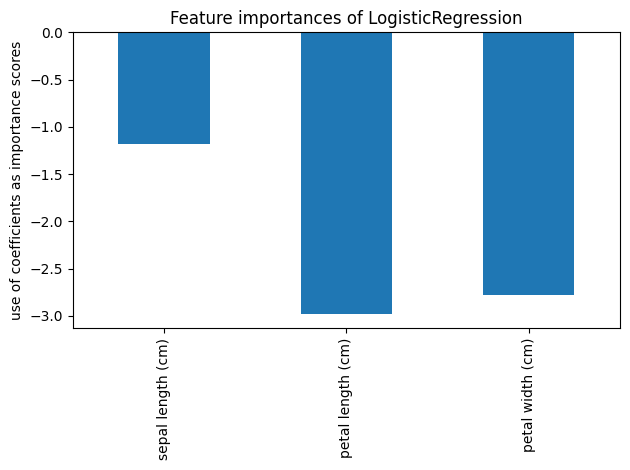

In [12]:
model.feature_importance()

predict with your model

In [13]:
test_df = pd.DataFrame([[1.3, 1.3, 1.3, 1.3], [6.5, 1.6, 8.6, 2.4]], columns=['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'])
test_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,1.3,1.3,1.3,1.3
1,6.5,1.6,8.6,2.4


**IMPORTANT:** if you are not using a pipeline, you have to apply all the data preparation steps (without sampling) also to your data that shall be predicted

In [14]:
test_df = scaler.scale(test_df, train_on=False)
test_df = selector.select(test_df, train_on=False)

In [15]:
model.predict(test_df)

[0, 2]

### 3.2. hyperparameter tuning

you can get the hyperparameter tuning grid as followed:

In [16]:
model.grid

Configuration space object:
  Hyperparameters:
    C, Type: UniformFloat, Range: [0.01, 100.0], Default: 1.0, on log-scale
    l1_ratio, Type: UniformFloat, Range: [0.01, 1.0], Default: 0.1
    penalty, Type: Categorical, Choices: {l2, elasticnet}, Default: l2
    solver, Type: Categorical, Choices: {newton-cg, lbfgs, liblinear, sag, saga}, Default: lbfgs, Probabilities: (0.15, 0.15, 0.15, 0.15, 0.4)
  Conditions:
    l1_ratio | penalty == 'elasticnet'
  Forbidden Clauses:
    (Forbidden: penalty == 'elasticnet' && Forbidden: solver in {'lbfgs', 'liblinear', 'newton-cg', 'sag'})

#### 3.2.1. recall optimization (with recall_score function)

simple scoring with recall/precision/accurracy

In [17]:
best_hyperparam, best_score = model.randomCVsearch(x_train, y_train, scoring="recall", avg="macro")
best_hyperparam, best_score

randomCVsearch (LogisticRegression):   0%|          | 0/10 [00:00<?, ?it/s]

({'C': 63.512210106407046, 'penalty': 'l2', 'solver': 'lbfgs'},
 0.948015873015873)

In [18]:
best_model = model.get_deepcopy()
best_model.set_params(**best_hyperparam)
best_model.train(x_train, y_train)
best_model.evaluate(x_test, y_test)

Train score:  0.959349593495935  - Train time:  0:00:00
accuracy:  1.0
precision:  [1. 1. 1.]
recall:  [1. 1. 1.]
s_score:  0.9926004570086354
l_score:  1.0

classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



{'accuracy': 1.0,
 'precision': array([1., 1., 1.]),
 'recall': array([1., 1., 1.]),
 's_score': 0.9926004570086354,
 'l_score': 1.0}

#### 3.2.2. recall optimization (with s_scoring function)

advanced scoring with s_score/l_score:
- **secondary_scoring** and **pos_label** to priorities metrics/classes in optimization
- **strength** to set how much the priorization is compared to scores in all the other metrics/classes
- always includes all metrics/classes and punishes really bad scores in one metric/class

In [19]:
best_hyperparam, best_score = model.randomCVsearch(x_train, y_train, scoring="s_score", secondary_scoring="recall", pos_label=-1, strength=4)
best_hyperparam, best_score

randomCVsearch (LogisticRegression):   0%|          | 0/10 [00:00<?, ?it/s]

({'C': 2.463768595899747, 'penalty': 'l2', 'solver': 'newton-cg'},
 0.9242160422494159)

In [20]:
best_model = model.get_deepcopy()
best_model.set_params(**best_hyperparam)
best_model.train(x_train, y_train)
best_model.evaluate(x_test, y_test)

Train score:  0.9512195121951219  - Train time:  0:00:00
accuracy:  1.0
precision:  [1. 1. 1.]
recall:  [1. 1. 1.]
s_score:  0.9926004570086354
l_score:  1.0

classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



{'accuracy': 1.0,
 'precision': array([1., 1., 1.]),
 'recall': array([1., 1., 1.]),
 's_score': 0.9926004570086354,
 'l_score': 1.0}

#### 3.2.3. SMAC3 library *HyperparameterOptimizationFacade*

In [21]:
best_hyperparam = model.smac_search(x_train, y_train, scoring="recall", avg="macro")
best_hyperparam

[INFO][abstract_initial_design.py:147] Using 3 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:305] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:515] Added config 12be8a as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:590] Added config ce10f4 and rejected config 12be8a as incumbent because it is not better than the incumbents on 1 instances:
[INFO][configspace.py:175] --- C: 1.521010951219768 -> 68.66295315779564
[INFO][configspace.py:175] --- solver: 'sag' -> 'lbfgs'
[INFO][abstract_intensifier.py:590] Added config 0b341b and rejected config ce10f4 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][configspace.py:175] --- C: 68.66295315779564 -> 2.218460698162247
[INFO][configspace.py:175] --- solver: 'lbfgs' -> 'saga'
[INFO][smbo.py:319] Finished 50 trials.
[INFO][smbo.py:327] Configuration budget is exhausted:
[INFO][smbo.py:328] --- Rema

Configuration(values={
  'C': 2.218460698162247,
  'penalty': 'l2',
  'solver': 'saga',
})

In [22]:
best_model = model.get_deepcopy()
best_model.set_params(**best_hyperparam)
best_model.train(x_train, y_train)
best_model.evaluate(x_test, y_test)

Train score:  0.9512195121951219  - Train time:  0:00:00
accuracy:  1.0
precision:  [1. 1. 1.]
recall:  [1. 1. 1.]
s_score:  0.9926004570086354
l_score:  1.0

classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



{'accuracy': 1.0,
 'precision': array([1., 1., 1.]),
 'recall': array([1., 1., 1.]),
 's_score': 0.9926004570086354,
 'l_score': 1.0}

### 3.3. crossvalidation

#### 3.3.1. all-vs-one cross validation

**Concept:**

The model will be trained on all datapoints except one and then tested on this last one. This will be repeated for all datapoints so that we have our predictions for all datapoints.

**Advantage:** optimal use of information for training

**Disadvantage:** long train time

This concept is very useful for small datasets (datapoints < 150) because the long train time is still not too long and especially with a small amount of information for the model, it is important to use all the information one has for the training.

In [23]:
model.cross_validation_small_data(X, y, avg="macro")

LogisticRegression:   0%|          | 0/150 [00:00<?, ?it/s]


classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.96      0.94      0.95        50
           2       0.94      0.96      0.95        50

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



{'accuracy': 0.9666666666666667,
 'precision': 0.9667867146858743,
 'recall': 0.9666666666666667,
 's_score': 0.9885291351907307,
 'l_score': 0.9999999880691252,
 'train_score': 0.9734675615212528,
 'train_time': '0:00:00'}

#### 3.3.2. multiple split cross validation

In [24]:
model.cross_validation(X, y, cv_num=5, avg="macro")


                                0         1         2         3         4  \
fit_time                 0.014723  0.016851  0.018619  0.023856  0.023713   
score_time               0.007517  0.007146  0.008334  0.009756  0.006519   
test_precision (macro)   1.000000  1.000000  0.500000  0.916667  0.500000   
train_precision (macro)  0.973825  0.971997  1.000000  0.941667  0.987179   
test_recall (macro)      1.000000  1.000000  0.433333  0.950000  0.416667   
train_recall (macro)     0.973333  0.968333  1.000000  0.941667  0.966667   
test_accuracy            1.000000  1.000000  0.866667  0.933333  0.833333   
train_accuracy           0.966667  0.966667  1.000000  0.950000  0.983333   
test_s_score             0.997527  0.995061  0.002455  0.984473  0.002447   
train_s_score            0.989409  0.988808  0.992600  0.983390  0.989049   
test_l_score             1.000000  1.000000  0.000000  0.999980  0.000000   
train_l_score            1.000000  1.000000  1.000000  0.999999  1.000000  

{'accuracy': 0.9266666666666665,
 'precision': 0.7833333333333334,
 'recall': 0.76,
 's_score': 0.5963926326514177,
 'l_score': 0.5999959011044498,
 'train_score': 0.9733333333333334,
 'train_time': '0:00:00'}

### 3.4. save and load models

save your classifier class object with **only_estimator**=False or you can only save the sklearn model with **only_estimator**=True

In [25]:
model.save_model(path="rfc.pkl", only_estimator=False)

every *Model* subclass (*Classifier*, *Pipeline*, *RFC*, ...) has the *load_model* function that returns the model

In [26]:
loaded_model = LR.load_model(path="rfc.pkl")